In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix, classification_report
from sklearn.model_selection import StratifiedKFold
import itertools
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, precision_score, confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score,recall_score






In [ ]:

test_datagen = ImageDataGenerator(rescale=1./255)


def load_data_paths_labels(base_dir):
    image_paths, labels = [], []
    for category in ['Normal', 'Non-COVID']:
        category_dir = os.path.join(base_dir, category, 'images')
        for img_name in os.listdir(category_dir):
            if img_name.lower().endswith(('.png', '.jpg', '.jpeg')) and not img_name.startswith('.'):
                image_paths.append(os.path.join(category_dir, img_name))
                labels.append(0 if category == 'Normal' else 1)
    return image_paths, labels



test_image_paths, test_labels = load_data_paths_labels('/content/drive/MyDrive/FYP/Dataset/Classification/Test')

# Convert to DataFrame for flow_from_dataframe

test_df = pd.DataFrame({'filename': test_image_paths, 'category': test_labels})

# Convert 'category' to string labels

test_df['category'] = test_df['category'].astype(str)

In [ ]:
inception_model_path = '/content/drive/MyDrive/FYP/Implemention/inspectionV3_pneumonia_detection.h5'
vgg16_model_path = '/content/drive/MyDrive/FYP/Implemention/new_vgg16_pneumonia_detection.h5'
resnet_model_path = '/content/drive/MyDrive/FYP/Implemention/Resnet50_pneumonia_detection.h5'

In [ ]:
test_generator = test_datagen.flow_from_dataframe(
    test_df,
    x_col='filename',
    y_col='category',
    target_size=(224, 224),
    class_mode='binary',
    batch_size=32,
    shuffle=False,
    prefetch=3,# Important for evaluation to maintain order
)

inception_model = load_model(inception_model_path)
vgg16_model = load_model(vgg16_model_path)
resnet_model = load_model(resnet_model_path)
test_generator.reset()
models = [inception_model, vgg16_model, resnet_model]
weights = [0.2, 0.3, 0.5]
weights = np.array(weights) / np.sum(weights)
preds = np.array([model.predict(test_generator) for model in models])
weighted_preds = np.tensordot(preds, weights, axes=((0), (0)))
binary_predictions = [1 if x > 0.6 else 0 for x in weighted_preds]


Found 4393 validated image filenames belonging to 2 classes.
138/138 [==============================] - 23s 161ms/step


In [ ]:
test_generator = test_datagen.flow_from_dataframe(
    test_df,
    x_col='filename',
    y_col='category',
    target_size=(224, 224),
    class_mode='binary',
    batch_size=32,
    shuffle=False
)

# Load models
inception_model = load_model(inception_model_path)
vgg16_model = load_model(vgg16_model_path)
resnet_model = load_model(resnet_model_path)
models = [inception_model, vgg16_model, resnet_model]

# Weights for ensemble
weights = [0.2, 0.3, 0.5]
weights = np.array(weights) / np.sum(weights)

# Get predictions from each model
preds = np.array([model.predict(test_generator, verbose=1) for model in models])
preds = np.squeeze(preds, axis=-1)  # Ensure preds are correctly shaped

# Calculate weighted average of predictions
weighted_preds = np.tensordot(preds, weights, axes=((0), (0)))

# Convert probabilities to binary predictions
binary_predictions = [1 if x > 0.6 else 0 for x in weighted_preds]

# Now, compare binary_predictions with true_labels to evaluate performance


Found 4393 validated image filenames belonging to 2 classes.
138/138 [==============================] - 21s 148ms/step


In [ ]:
true_labels = test_generator.classes
accuracy = accuracy_score(true_labels, binary_predictions)
f1 = f1_score(true_labels, binary_predictions)
precision = precision_score(true_labels, binary_predictions)
recall = recall_score(true_labels, binary_predictions)

print(f'Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}')

Accuracy: 0.8650, F1 Score: 0.8645, Precision: 0.8911, Recall: 0.8393


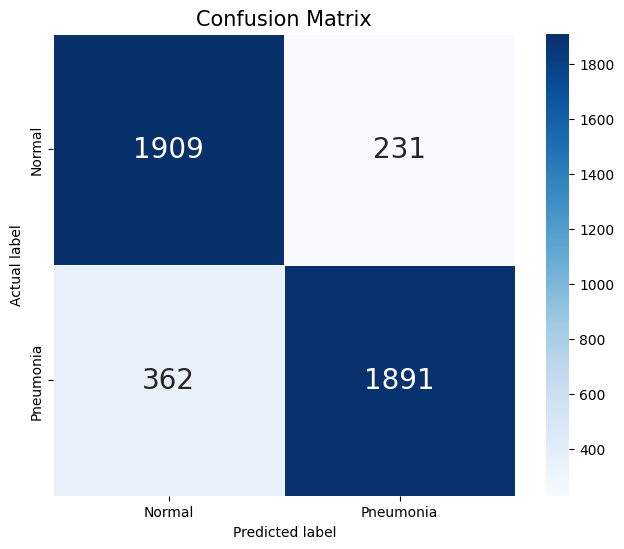

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(true_labels, binary_predictions, class_names):

    cm = confusion_matrix(true_labels, binary_predictions)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt="d", linewidths=.5, square=True, cmap='Blues', annot_kws={"size": 20},
                xticklabels=class_names, yticklabels=class_names)

    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.title('Confusion Matrix', size = 15)
    plt.show()

plot_confusion_matrix(true_labels, binary_predictions, ['Normal', 'Pneumonia'])

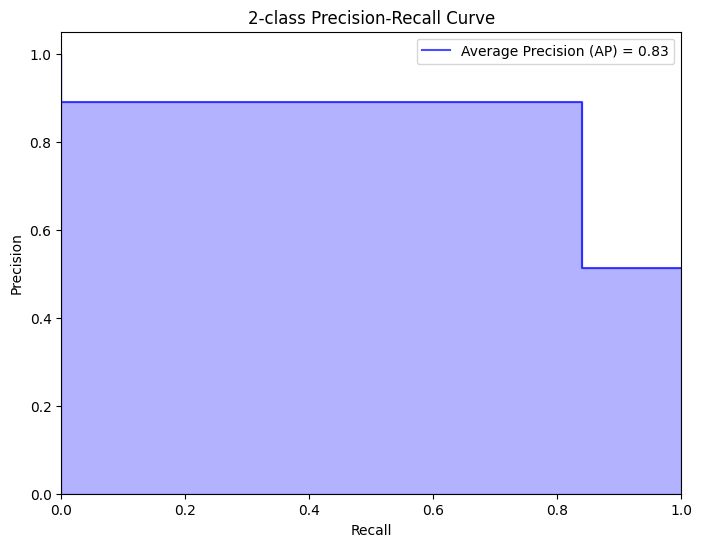

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score

def plot_precision_recall_curve(true_labels, binary_predictions):

    precision, recall, _ = precision_recall_curve(true_labels, binary_predictions)
    average_precision = average_precision_score(true_labels, binary_predictions)

    plt.figure(figsize=(8, 6))
    plt.step(recall, precision, where='post', color='b', alpha=0.7, label=f'Average Precision (AP) = {average_precision:.2f}')
    plt.fill_between(recall, precision, step='post', alpha=0.3, color='b')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('2-class Precision-Recall Curve')
    plt.legend(loc="upper right")
    plt.show()
plot_precision_recall_curve(true_labels, binary_predictions)